# EDA Question 1

**Business Goal 1:** Between the two top teams of 2021-2022 (UNC and Kansas) which has higher reddit engagement.

**Technical Proposal:** Use regular expressions to extract mentions of the UNC and Kansas basketball team from the College Basketball subreddit to determine which is more talked about. Additionally, compute the counts of comments and submissions by day in the respective subreddits of UNC and Kansas basketball to determine which days have the most engagement for each fanbase. Finally also compute a count of comments by day in the large College Basketball subreddit to determine high engagement days in the overall college basketball community. 

In [1]:
#| output: false
#| echo: false
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 6, Finished, Available)

In [2]:
#| output: false
#| echo: false

workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 7, Finished, Available)

In [3]:
#| echo: false
#| output: false

#datastore = 'azureml://datastores/workspaceblobstore/paths'
comments_path = "/basketball_comments_sep.parquet"
submissions_path = "/basketball_submissions_sep.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

comments = comments.cache()
submissions = submissions.cache()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 8, Finished, Available)

In [7]:
#| echo: false
#| output: false

comments.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 12, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+
|CollegeBasketball|  joeveralls|:cincinnati: :ohi...|Nothing is fallin...| t3_qtcawg|t3_qtcawg|hkiuknu|2021-11-14 00:27:16|
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+
only showing top 3 rows



In [8]:
#| echo: false
#| output: false

submissions.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 27, 13, Finished, Available)

+-----------------+---------------+--------------------+--------------------+---------+-------------------+------------+
|        subreddit|         author|   author_flair_text|               title| selftext|        created_utc|num_comments|
+-----------------+---------------+--------------------+--------------------+---------+-------------------+------------+
|CollegeBasketball|   MrSmartShart|:texastech: Texas...|When is the first...|         |2022-03-17 13:28:37|           0|
|CollegeBasketball|    wavyboimike|:houston: Houston...|        New Upsets ?|[removed]|2022-03-17 13:30:14|           2|
|CollegeBasketball|IncessantStress|                null|  Sportsline Bracket|[removed]|2022-03-17 13:31:31|           0|
+-----------------+---------------+--------------------+--------------------+---------+-------------------+------------+
only showing top 3 rows



In [5]:
#| echo: false
#| output: false

from pyspark.sql.functions import col, to_date, desc

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 10, Finished, Available)

In [7]:
#| echo: false
#| output: false

comments.filter(col('body').isNull()).count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 31, 12, Finished, Available)

0

In [8]:
#| echo: false
#| output: false

submissions.filter(col('selftext').isNull()).count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 31, 13, Finished, Available)

0

In [6]:
#| echo: false
#| output: false

comments = comments.filter(comments.body != '')
submissions = submissions.filter((submissions.selftext != '[removed]') & 
                                 (submissions.selftext != '[deleted]') &
                                 (submissions.selftext != ''))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 11, Finished, Available)

## Exploratory analysis

### EDA of comments data

First, let's look at the comments data.

In [10]:
#| echo: false
#| output: false

type(comments)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 31, 15, Finished, Available)

pyspark.sql.dataframe.DataFrame

In [12]:
#| echo: false
#| output: false

comments.columns

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 17, Finished, Available)

['subreddit',
 'author',
 'author_flair_text',
 'body',
 'parent_id',
 'link_id',
 'id',
 'created_utc']

In [12]:
#| echo: false
#| output: false

comments.printSchema()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 31, 17, Finished, Available)

root
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)



In [7]:
#| echo: false
#| output: false

from pyspark.sql.functions import col, to_date, desc
import pyspark.sql.functions as F

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 12, Finished, Available)

Let's find out which team is more popular in reddit comments.

In [12]:
#| output: false

comments_popular = comments.withColumn('mention_jayhawks',
                                        F.when(F.regexp_extract(col('body'), 'jayhawks',0) == 'jayhawks', 1).otherwise(0))
comments_popular = comments_popular.withColumn('mention_tarheels',
                                        F.when(F.regexp_extract(col('body'), 'tarheels',0) == 'tarheels', 1).otherwise(0))
#reference: https://blog.devgenius.io/regular-expression-regexp-in-pyspark-e5f9b5d9617a                 

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 17, Finished, Available)

In [14]:
comments_popular.groupBy('mention_jayhawks').count().show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 19, Finished, Available)

+----------------+-------+
|mention_jayhawks|  count|
+----------------+-------+
|               1|     90|
|               0|1575077|
+----------------+-------+



In [15]:
comments_popular.groupBy('mention_tarheels').count().show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 20, Finished, Available)

+----------------+-------+
|mention_tarheels|  count|
+----------------+-------+
|               1|     41|
|               0|1575126|
+----------------+-------+



Among all the comments, 90 comments mention 'jayhawks' and 41 comments mention 'tarheels'. The numbers are both not really huge. To see the popularity of a team, maybe we should look at more words related to the team, like 'Kansas' and 'jayhawks' and so on. 

In the comments dataset, there is a column named 'created_utc' which contains the information of when the comments were posted. Let's extract only the date information from it.

In [8]:
#| echo: false
#| output: false

comments_eda = comments.withColumn('date', to_date(col('created_utc')))
#reference: https://www.projectpro.io/recipes/explain-conversion-of-timestamp-date-pyspark-databricks#:~:text=To%20convert%20a%20datetime%20to,input%20and%20returns%20a%20date.

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 34, 13, Finished, Available)

In [15]:
#| echo: false
#| output: false

comments_eda.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 31, 20, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+----------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|      date|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+----------+
|CollegeBasketball|  joeveralls|:cincinnati: :ohi...|Nothing is fallin...| t3_qtcawg|t3_qtcawg|hkiuknu|2021-11-14 00:27:16|2021-11-14|
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|2021-11-14|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|2021-11-14|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+----------+
only showing top 3 rows



Our project focus on collegiate basketball and the two most successful teams during this basketball season which ranges from November 2021 to around March 2022.

In [11]:
#| echo: false
#| output: false

comments_eda.select('subreddit').distinct().show()
#reference: https://stackoverflow.com/questions/39383557/show-distinct-column-values-in-pyspark-dataframe

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 29, 16, Finished, Available)

+-----------------+
|        subreddit|
+-----------------+
|         jayhawks|
|CollegeBasketball|
|         tarheels|
+-----------------+



'jayhawks' is about the Kansas team and 'tarheels' is about the UNC team.

Let's find out which days had the most comments.

In [10]:

comments_eda.groupBy('date') \
            .count() \
            .sort(desc('count')) \
            .show(10)
#reference: https://sparkbyexamples.com/pyspark/pyspark-dataframe-groupby-and-sort-by-descending-order/
#           https://www.geeksforgeeks.org/pyspark-groupby-dataframe-with-aggregation-or-count/

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 29, 15, Finished, Available)

+----------+-----+
|      date|count|
+----------+-----+
|2022-03-19|59485|
|2022-03-18|52046|
|2022-03-20|49716|
|2022-03-21|41322|
|2022-03-17|40123|
|2022-03-25|38882|
|2022-03-26|35700|
|2022-04-05|35635|
|2022-03-12|35390|
|2022-03-13|34023|
+----------+-----+
only showing top 10 rows




From this dataframe, we can know that days from March 2022 to April 2022 had the most reddit engagement. It makes sense because our project focuses on the whole basketball season which ranges from November 2021 to around March 2022, and March 2022 is the end of the basketball season. People will get extremely excited at the end of the basketball season and definitely lots of people will be talking about the games like the possible champion of this season.

Between the two most successful teams in this season, which team had the most reddit engagement?

In [9]:
#| output: false

df_eda = comments_eda.groupBy('date', 'subreddit') \
                     .count() \
                     .sort(desc('count'))
#reference:https://www.geeksforgeeks.org/pyspark-groupby-and-sort-dataframe-in-descending-order/
#          https://sparkbyexamples.com/pyspark/pyspark-groupby-on-multiple-columns/

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 34, 14, Finished, Available)

In [21]:
#| echo: false
#| output: false

df_eda.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 26, Finished, Available)

+----------+-----------------+-----+
|      date|        subreddit|count|
+----------+-----------------+-----+
|2022-03-19|CollegeBasketball|59227|
|2022-03-18|CollegeBasketball|51876|
|2022-03-20|CollegeBasketball|49672|
+----------+-----------------+-----+
only showing top 3 rows



The most comments are in the subreddit 'CollegeBasketball'.

Then let's focus on the two most successful teams in this season.

In [17]:

df_eda.where((col('subreddit') == 'jayhawks') | (col('subreddit') == 'tarheels')).show(5)
#reference: https://medium.com/@uzzaman.ahmed/how-to-use-where-and-filter-in-a-dataframe-with-examples-bc2a9544ae3f#:~:text=In%20Apache%20Spark%2C%20the%20where,evaluates%20to%20False%20are%20removed.

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 31, 22, Finished, Available)

+----------+---------+-----+
|      date|subreddit|count|
+----------+---------+-----+
|2022-04-05| jayhawks|  900|
|2022-03-27| jayhawks|  280|
|2022-03-19| jayhawks|  215|
|2022-03-26| jayhawks|  212|
|2022-04-02| jayhawks|  208|
+----------+---------+-----+
only showing top 5 rows



wow! It seems that 'jayhawks' had more reddit engagement. It also makes sense because the Kansas team is the winner of this season. We can image people screaming, shouting and sending comments after the Kansas team won.

In [10]:
#| output: false

df_eda_comments = df_eda.where((col('subreddit') == 'jayhawks') | (col('subreddit') == 'tarheels'))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 34, 15, Finished, Available)

In [11]:
#| output: false

df_eda_comments = df_eda_comments.orderBy('date')
#reference:https://sparkbyexamples.com/pyspark/pyspark-orderby-and-sort-explained/

df_eda_comments_pd = df_eda_comments.toPandas()
#reference: https://sparkbyexamples.com/python/convert-pyspark-dataframe-to-pandas/

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 34, 16, Finished, Available)

In [13]:
#| output: false
comments_jayhawks = df_eda_comments_pd[df_eda_comments_pd['subreddit'] == 'jayhawks']
comments_tarheels = df_eda_comments_pd[df_eda_comments_pd['subreddit'] == 'tarheels']
#reference:https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 34, 18, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 34, 24, Finished, Available)

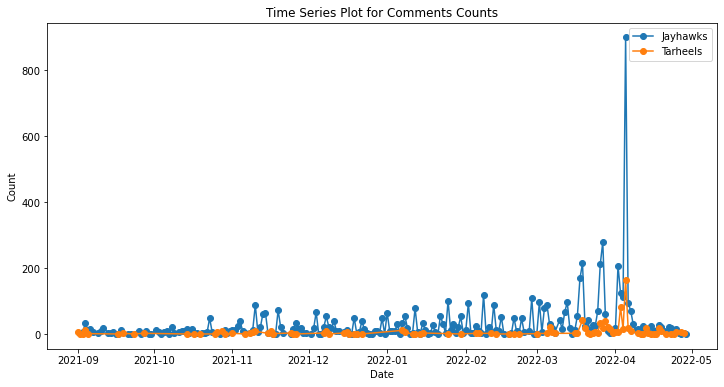

In [19]:
#| echo: false
#| output: false

import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.plot(comments_jayhawks['date'],comments_jayhawks['count'], label = 'Jayhawks', marker = 'o')
plt.plot(comments_tarheels['date'],comments_tarheels['count'], label = 'Tarheels', marker = 'o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot for Comments Counts')
plt.legend()
#reference: https://www.tutorialspoint.com/plot-multiple-lines-in-matplotlib

### EDA of submissions data

Let's see the popularity of both teams in reddit submissions.

In [16]:
#| echo: false
#| output: false

submissions_popular = submissions.withColumn('mention_jayhawks',
                                        F.when(F.regexp_extract(col('selftext'), 'jayhawks',0) == 'jayhawks', 1).otherwise(0))
submissions_popular = submissions_popular.withColumn('mention_tarheels',
                                        F.when(F.regexp_extract(col('selftext'), 'tarheels',0) == 'tarheels', 1).otherwise(0))
#reference: https://blog.devgenius.io/regular-expression-regexp-in-pyspark-e5f9b5d9617a

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 21, Finished, Available)

In [18]:
#| echo: false
#| output: false

submissions_popular.groupBy('mention_jayhawks').count().show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 23, Finished, Available)

+----------------+-----+
|mention_jayhawks|count|
+----------------+-----+
|               0| 9799|
|               1|    5|
+----------------+-----+



In [19]:
#| echo: false
#| output: false

submissions_popular.groupBy('mention_tarheels').count().show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 35, 24, Finished, Available)

+----------------+-----+
|mention_tarheels|count|
+----------------+-----+
|               0| 9803|
|               1|    1|
+----------------+-----+



Similarly, extract the date information from the 'created_utc' column.

In [30]:
#| echo: false
#| output: false

submissions_eda = submissions.withColumn('date',to_date(col('created_utc')))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 35, Finished, Available)

Some days in November 2021 and days in around February 2022 and March 2022 have the most submissions. This season starts in November 2021, and people must be excited about the start of a new basketball season. And when the end of the season came, people would talk about the performances in different games and so on.

In [35]:


submissions_eda.groupBy('date', 'subreddit') \
               .count() \
               .sort(desc('count')) \
               .show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 40, Finished, Available)

+----------+-----------------+-----+
|      date|        subreddit|count|
+----------+-----------------+-----+
|2021-11-10|CollegeBasketball|  186|
|2021-11-13|CollegeBasketball|  137|
|2022-03-06|CollegeBasketball|  126|
|2022-03-11|CollegeBasketball|  126|
|2022-02-12|CollegeBasketball|  118|
+----------+-----------------+-----+
only showing top 5 rows



Let's focus on the submissions in the subreddit 'jayhawks' and the subreddit 'tarheels'.

In [39]:
df_eda_2 = submissions_eda.groupBy('date','subreddit') \
                          .count() \
                          .sort(desc('count'))
df_eda_2.where((col('subreddit') == 'jayhawks') | (col('subreddit') == 'tarheels')).show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 44, Finished, Available)

+----------+---------+-----+
|      date|subreddit|count|
+----------+---------+-----+
|2022-04-05| jayhawks|    8|
|2022-04-04| jayhawks|    7|
|2022-03-27| jayhawks|    6|
|2022-04-05| tarheels|    5|
|2022-04-03| jayhawks|    5|
+----------+---------+-----+
only showing top 5 rows



'jayhawks' have the most submissions in April 2022. Certainly! They won!

In [41]:
#| echo: false
#| output: false

df_eda_submissions = df_eda_2.where((col('subreddit') == 'jayhawks') | (col('subreddit') == 'tarheels')) 
df_eda_submissions.show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 46, Finished, Available)

+----------+---------+-----+
|      date|subreddit|count|
+----------+---------+-----+
|2022-04-05| jayhawks|    8|
|2022-04-04| jayhawks|    7|
|2022-03-27| jayhawks|    6|
|2022-04-05| tarheels|    5|
|2022-04-03| jayhawks|    5|
+----------+---------+-----+
only showing top 5 rows



In [43]:
#| echo: false
#| output: false

df_eda_submissions = df_eda_submissions.orderBy('date')
df_eda_submissions_pd = df_eda_submissions.toPandas()
df_eda_submissions.show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 48, Finished, Available)

+----------+---------+-----+
|      date|subreddit|count|
+----------+---------+-----+
|2021-09-01| tarheels|    1|
|2021-09-01| jayhawks|    1|
|2021-09-03| jayhawks|    2|
|2021-09-05| jayhawks|    1|
|2021-09-06| jayhawks|    1|
+----------+---------+-----+
only showing top 5 rows



In [46]:
#| echo: false
#| output: false

submissions_jayhawks = df_eda_submissions_pd[df_eda_submissions_pd['subreddit'] == 'jayhawks']
submissions_tarheels = df_eda_submissions_pd[df_eda_submissions_pd['subreddit'] == 'tarheels']

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 51, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 32, 57, Finished, Available)

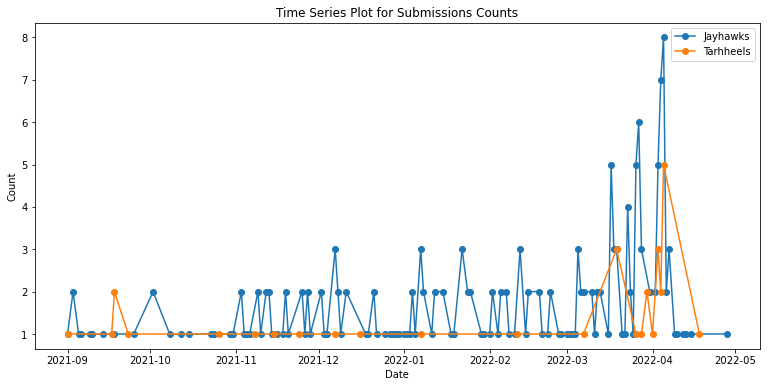

In [52]:
#| echo: false
#| output: false

plt.figure(figsize = (13,6))
plt.plot(submissions_jayhawks['date'], submissions_jayhawks['count'], label = 'Jayhawks', marker = 'o')
plt.plot(submissions_tarheels['date'], submissions_tarheels['count'], label = 'Tarhheels', marker = 'o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot for Submissions Counts')
plt.legend()

***Work completed by Shihong Zhou***
